In [1]:
import os
import pandas as pd
import geopandas
import numpy as np
import folium
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy.stats as stats

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
sns.set_context("talk")

pd.set_option('display.max_columns', None)

In [2]:
city = 'munich'

In [3]:
data = pd.read_csv(f"data/{city}.csv")
data.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,651278636295313943,https://www.airbnb.com/rooms/651278636295313943,20230627053437,2023-06-27,city scrape,Condo in Munich · ★4.38 · 1 bedroom · 2 beds ·...,NaN,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,286578863,https://www.airbnb.com/users/show/286578863,Tobias,2019-08-17,"Munich, Germany","Hey there, my name is Tobias, I‘m from Austria...",within an hour,100%,100%,f,https://a0.muscache.com/im/pictures/user/a01df...,https://a0.muscache.com/im/pictures/user/a01df...,NaN,1,2,"['email', 'phone', 'work_email']",t,t,NaN,Bogenhausen,NaN,48.173418,11.635056,Entire condo,Entire home/apt,3,NaN,1 bath,1.0,2.0,"[""TV"", ""First aid kit"", ""Smoke alarm"", ""Elevat...",$104.00,1,14,1,1,1125,1125,1.0,1125.0,NaN,t,12,32,38,38,2023-06-27,24,24,4,2022-09-18,2023-06-23,4.38,4.75,4.50,4.79,4.79,4.17,4.38,NaN,t,1,1,0,0,2.54
1,51979073,https://www.airbnb.com/rooms/51979073,20230627053437,2023-06-27,previous scrape,Rental unit in Munich · ★4.61 · 1 bedroom · 2 ...,Enjoy the simple life in this quiet and centra...,Maxvorstadt is a bustling district: it is home...,https://a0.muscache.com/pictures/a149c822-8207...,146200788,https://www.airbnb.com/users/show/146200788,Dustin,2017-08-15,"Munich, Germany",NaN,a few days or more,33%,27%,f,https://a0.muscache.com/im/pictures/user/8d2e2...,https://a0.muscache.com/im/pictures/user/8d2e2...,NaN,1,1,"['email', 'phone']",t,t,"Munich, Bayern, Germany",Maxvorstadt,NaN,48.149384,11.576812,Entire rental unit,Entire home/apt,2,NaN,1 bath,1.0,2.0,"[""Freezer"", ""Hangers"", ""Clothing storage: clos...",$72.00,5,365,3,3,365,365,3.0,365.0,NaN,t,0,0,0,0,2023-06-27,18,6,0,2021-09-18,2023-03-12,4.61,4.67,4.44,4.78,4.67,4.83,4.61,NaN,f,1,1,0,0,0.83
2,44605632,https://www.airbnb.com/rooms/44605632,20230627053437,2023-06-27,previous scrape,Rental unit in Munich · ★5.0 · 2 bedrooms · 2 ...,Centrally located in Munich's trending but qui...,5-min walk to trams<br />8-minute walk from po...,https://a0.muscache.com/pictures/13da8e75-9778...,7936197,https://www.airbnb.com/users/show/7936197,Waleska,2013-08-04,"Munich, Germany",With nearly 10 consecutive years living abroad...,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/61ebf...,https://a0.muscache.com/im/pictures/user/61ebf...,NaN,1,2,"['email', 'phone', 'work_email']",t,t,"Munich, Bayern, Germany",Schwanthalerhöhe,NaN,48.139170,11.529930,Entire rental unit,Entire home/apt,4,NaN,1 bath,2.0,2.0,"[""Freezer"", ""Hangers"", ""First aid kit"", ""Coffe...",$64.00,5,1125,5,5,1125,1125,5.0,1125.0,NaN,t,0,0,0,0,2023-06-27,7,0,0,2020-08-16,2022-04-20,5.00,5.00,5.00,5.00,5.00,4.86,5.00,NaN,t,1,1,0,0,0.20
3,44791381,https://www.airbnb.com/rooms/44791381,2023062705343

## Exploratory data analysis & data cleaning

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5677 entries, 0 to 5676
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            5677 non-null   int64  
 1   listing_url                                   5677 non-null   object 
 2   scrape_id                                     5677 non-null   int64  
 3   last_scraped                                  5677 non-null   object 
 4   source                                        5677 non-null   object 
 5   name                                          5677 non-null   object 
 6   description                                   5549 non-null   object 
 7   neighborhood_overview                         2521 non-null   object 
 8   picture_url                                   5677 non-null   object 
 9   host_id                                       5677 non-null   i

In [5]:
object_to_dtype = {
    "host_since": "datetime64[ns]",
    "host_response_rate": "float",
    "host_acceptance_rate": "float",
    "host_is_superhost": "bool",
    "host_has_profile_pic": "bool",
    "host_identity_verified": "bool",
    "instant_bookable": "bool",
    "has_availability": "bool",
}

for col, dtype in object_to_dtype.items():
    if dtype == "float":
        data[col] = data[col].str.replace("%", "").astype(dtype)
    elif dtype == "bool":
        data[col] = data[col].map({"t": True, "f": False}).astype(dtype)
    elif dtype == "datetime64[ns]":
        data[col] = pd.to_datetime(data[col])
    else:
        raise ValueError(f"Unknown dtype: {dtype}") 

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5677 entries, 0 to 5676
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            5677 non-null   int64         
 1   listing_url                                   5677 non-null   object        
 2   scrape_id                                     5677 non-null   int64         
 3   last_scraped                                  5677 non-null   object        
 4   source                                        5677 non-null   object        
 5   name                                          5677 non-null   object        
 6   description                                   5549 non-null   object        
 7   neighborhood_overview                         2521 non-null   object        
 8   picture_url                                   5677 non-null   object

In [7]:
# Convert daily price in local currency to float
data["price"] = data["price"].str.replace("$", "").str.replace(",", "").astype(float)

In [8]:
# Clean up the amenities column
data["amenities"] = data["amenities"].str.replace(r"\[|\]|\"", "")

In [9]:
# Remove outliers (price > 95% quantile)
data_cleaned = data[(data["price"] < data["price"].quantile(0.95)) & (data["minimum_nights"] <= 365)]
print(f"Rows dropped: {data.shape[0] - data_cleaned.shape[0]}")

Rows dropped: 286


In [10]:
# Extract numerical value from `bathrooms_text` column
data_cleaned["bathrooms"] = (
    data["bathrooms_text"].str.extract("(\d+\.?\d*)", expand=False).astype(float)
)

# Create new column `bathrooms_is_shared` indicating if bathroom is shared or not
data_cleaned["bathrooms_is_shared"] = data["bathrooms_text"].str.contains(
    "shared", case=False
)

In [11]:
# Fill NAs for bedrooms with median value of bedrooms by neighbourhood
data_cleaned["bedrooms"] = data_cleaned.groupby("neighbourhood_cleansed")[
    "bedrooms"
].transform(lambda x: x.fillna(x.median()))

In [12]:
# Add a column for number of key amenities provided
data["amenities"] = data["amenities"].str.replace(r"\[|\]|\"", "")

list_of_amenities = (
    data_cleaned["amenities"]
    .str.split(", ")
    .explode()
    .value_counts()
    .to_frame()
    .reset_index()
)
list_of_amenities.columns = ["amenities", "count"]
top_20_amenities = list_of_amenities.head(20)["amenities"].to_list()

data_cleaned["num_amenities"] = (
    data_cleaned["amenities"]
    .apply(lambda x: x.split(", "))
    .apply(lambda y: len(set(y).intersection(set(top_20_amenities))))
)

### What is the distribution of listing prices?

As we can see, there are no null values in the price column, but there appear to be some outliers in the data. Let's remove the listings with daily prices above the 95th percentile and see what the distribution looks like.

In [13]:
data['price'].describe()

count     5677.000000
mean       174.873877
std       1289.385944
min          0.000000
25%         69.000000
50%        100.000000
75%        179.000000
max      96274.000000
Name: price, dtype: float64

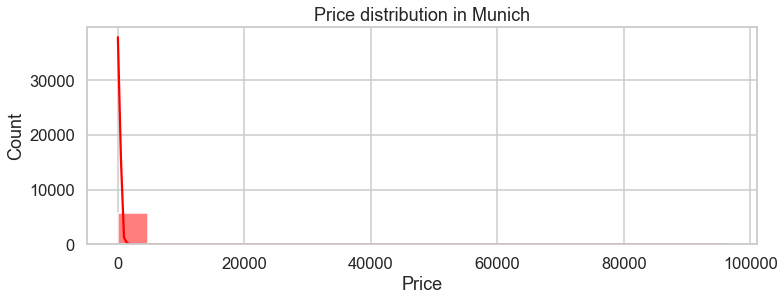

In [14]:
plt.figure(figsize=(12, 4))
ax = sns.histplot(data=data, x="price", color="r", bins=20, kde=True)
ax.set_title(f"Price distribution in {city.capitalize()}")
ax.set_xlabel("Price")
plt.show()

#### Outliers removed

After removing the outliers, the distribution of listing prices looks much more normal. 

The average price is $125 per night, with a standard deviation of ~$83. The distribution is slightly skewed to the right, which is expected with price data as there could be a fewer number of "luxury" listings that are much more expensive than the average listing.

In [15]:
data_cleaned['price'].describe()

count    5391.000000
mean      125.549063
std        82.719874
min         0.000000
25%        66.000000
50%        99.000000
75%       160.000000
max       442.000000
Name: price, dtype: float64

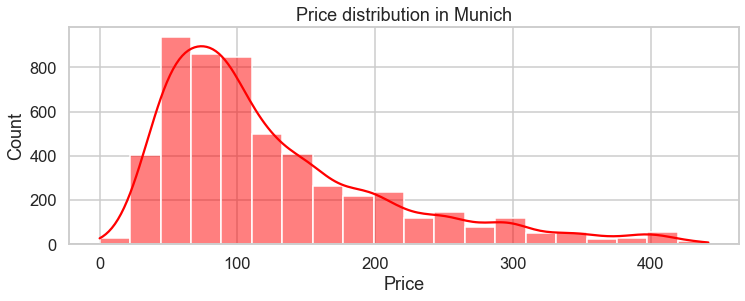

In [16]:
plt.figure(figsize=(12, 4))
ax = sns.histplot(data=data_cleaned, x="price", color="r", bins=20, kde=True)
ax.set_title(f"Price distribution in {city.capitalize()}")
ax.set_xlabel("Price")
plt.show()

### What is the relationship between the location of the listing (neighborhood) and the price?

We see that most listings are in the neighborhoods of Ludwigsvorstadt-Isarvorstadt, Maxvorstadt, Schwabing-West, Au-Haidhausen,Neuhausen-Nymphenburg and Schwabing-Freimann

In [17]:
# First, we check the `neighbourhood_cleansed` column
num_listings_by_neighborhood = (
    data_cleaned["neighbourhood_cleansed"]
    .value_counts()
    .to_frame()
    .reset_index()
)
num_listings_by_neighborhood.columns = ["neighbourhood_cleansed", "num_listings"]

num_listings_by_neighborhood.style.background_gradient(
    sns.light_palette("red", as_cmap=True)
).set_properties(**{"text-align": "center"}).set_table_styles(
    [
        dict(selector="th", props=[("text-align", "center")]),
        dict(
            selector="caption", props=[("font-size", "14px"), ("font-weight", "bold")]
        ),
    ],
).set_caption(
    f"Number of listings by neighborhood in {city.capitalize()}"
).relabel_index(
    {0: "Neighborhood", 1: "# of listings"},
    axis="columns",
).hide()

Neighborhood,# of listings
Ludwigsvorstadt-Isarvorstadt,653
Maxvorstadt,462
Schwabing-West,363
Au-Haidhausen,362
Neuhausen-Nymphenburg,316
Schwabing-Freimann,253
Bogenhausen,246
Thalkirchen-Obersendling-Forstenried-Fürstenried-Solln,217
Ramersdorf-Perlach,213
Sendling-Westpark,208


#### Average price by neighborhood

We can check the average price of the top 15 neighborhoods with the most listings. We see that the average price is highest in Outremont, followed by Ville-Marie and Le Plateau-Mont-Royal.

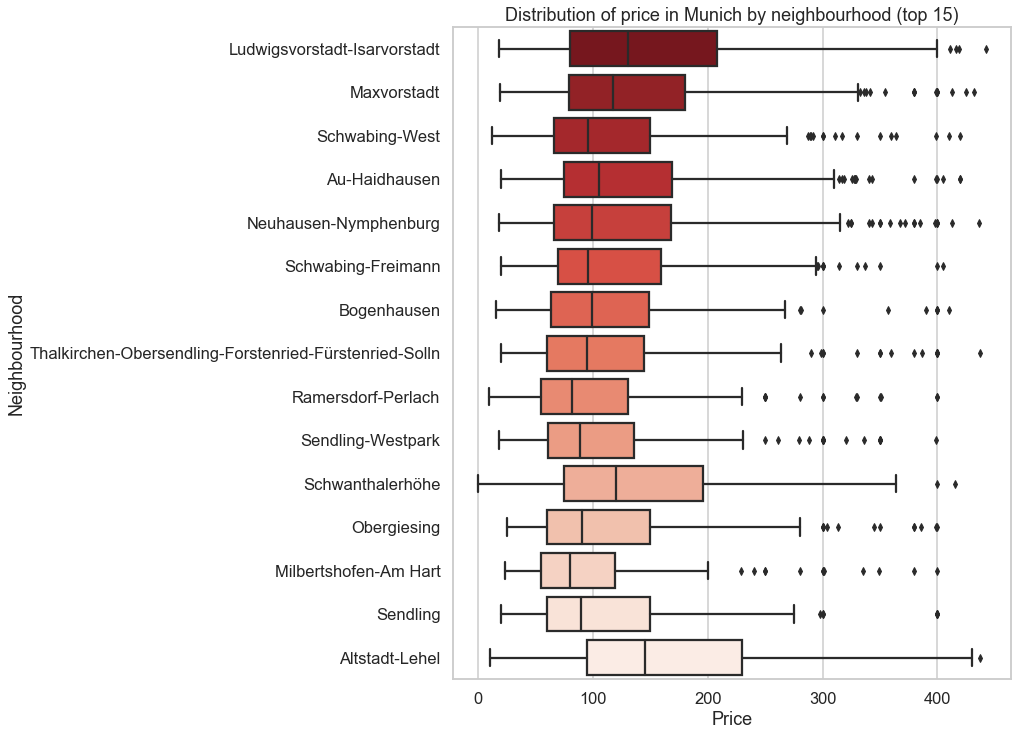

In [18]:
# Then, we see the price of listings in the top 15 neighbourhoods
plt.figure(figsize=(10, 12))
ax = sns.boxplot(
    data=data_cleaned[
        data_cleaned["neighbourhood_cleansed"].isin(
            num_listings_by_neighborhood.iloc[:15].neighbourhood_cleansed.values
        )
    ],
    y="neighbourhood_cleansed",
    x="price",
    order=num_listings_by_neighborhood.iloc[:15].neighbourhood_cleansed.values,
    palette="Reds_r"
)
ax.set_title(f"Distribution of price in {city.capitalize()} by neighbourhood (top 15)")
ax.set_ylabel("Neighbourhood")
ax.set_xlabel("Price")
plt.show()


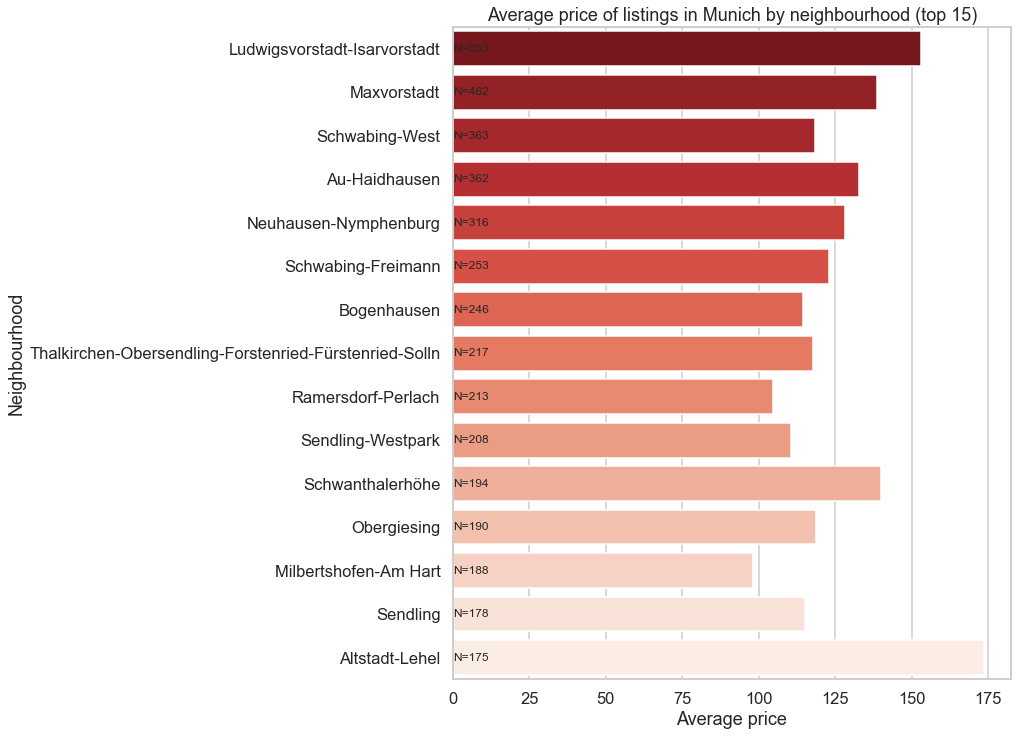

In [19]:
# Finally, we plot the mean price of listings in the top 15 neighbourhoods
avg_price_by_neighborhood = (
    (
        data_cleaned[
            data_cleaned["neighbourhood_cleansed"].isin(
                num_listings_by_neighborhood.iloc[:15].neighbourhood_cleansed.values
            )
        ]
        .groupby("neighbourhood_cleansed")["price"]
        .agg(["mean", "count"])
    )
    .reindex(index=num_listings_by_neighborhood.iloc[:15].neighbourhood_cleansed.values)
    .reset_index()
)

plt.figure(figsize=(10, 12))
ax = sns.barplot(
    avg_price_by_neighborhood,
    y="neighbourhood_cleansed",
    x="mean",
    order=num_listings_by_neighborhood.iloc[:15].neighbourhood_cleansed.values,
    palette="Reds_r",
)

for i in range(15):
    ax.text(
        0,
        i,
        f"N={avg_price_by_neighborhood.iloc[i]['count']}",
        va="center",
        fontsize=12,
    )

ax.set_title(
    f"Average price of listings in {city.capitalize()} by neighbourhood (top 15)"
)
ax.set_ylabel("Neighbourhood")
ax.set_xlabel("Average price")
plt.show()

The average price does vary by neighborhood, indicating that the location of the listing is an important factor in determining the price. We can conduct a statistical test to see if the difference in average price between neighborhoods is significant.

Since we have more than two groups, we will use [ANOVA](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html) to test if the difference in average price between neighborhoods is significant.

In [20]:
f_stat, p_value = stats.f_oneway(
    *data_cleaned.groupby("neighbourhood_cleansed")["price"]
    .apply(list)
    .reset_index()["price"]
    .values
)

print(f"f-statistic: {f_stat}")
print(f"p-value: {p_value}")

f-statistic: 11.147744564833417
p-value: 8.112219364343664e-42


Since the computed p-value is less than 0.05, we can reject the null hypothesis that the average price is the same across all neighborhoods. This means that the difference in average price between neighborhoods is statistically significant.

### How does the type of property (apartment, house, private room, shared room) affect the price?

We see that most listings are for entire apartments/houses, followed by private rooms. We can double-click on the legend to hide/show the different property types.

In [21]:
# First, we check the `room_type` column
num_listings_by_room_type = (
    data_cleaned["room_type"]
    .value_counts()
    .to_frame()
    .reset_index()
)
num_listings_by_room_type.columns = ["room_type", "num_listings"]
num_listings_by_room_type.style.background_gradient(
    sns.light_palette("red", as_cmap=True)
).set_properties(**{"text-align": "center"}).set_table_styles(
    [
        dict(selector="th", props=[("text-align", "center")]),
        dict(
            selector="caption", props=[("font-size", "14px"), ("font-weight", "bold")]
        ),
    ],
).hide().set_caption(
    f"Number of listings by room type in {city.capitalize()}"
).relabel_index(
    {0: "Room type", 1: "# of listings"},
    axis="columns",
)

Room type,# of listings
Entire home/apt,3465
Private room,1847
Shared room,44
Hotel room,35


Within the "Entire home/apt" room type, ~80% of the listings are for the entire unit. This indicates that the `property_type` column is redundant, and we can directly use `room_type` as a feature in our model.

In [22]:
data_cleaned[data_cleaned["room_type"] == "Entire home/apt"][
    "property_type"
].value_counts(normalize=True).to_frame()

,property_type
Entire rental unit,0.797980
Entire condo,0.103319
Entire serviced apartment,0.038384
Entire loft,0.021934
Entire home,0.015873
Entire townhouse,0.006349
Room in aparthotel,0.003752
Camper/RV,0.003463
Entire guest suite,0.002020
Entire villa,0.001154


#### Average price by room type

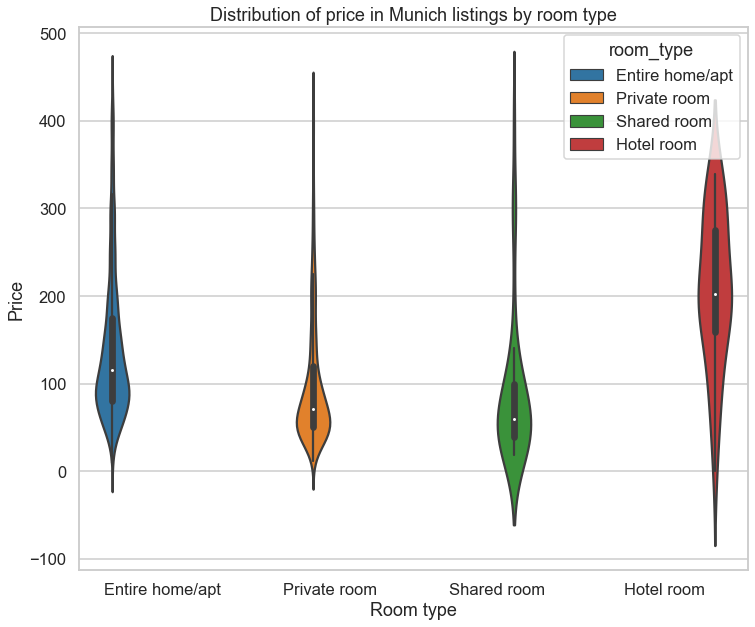

In [23]:
plt.figure(figsize=(12, 10))
ax = sns.violinplot(
    data=data_cleaned,
    x="room_type",
    y="price",
    hue="room_type",
    order=num_listings_by_room_type.room_type.values,
)
ax.set_title(f"Distribution of price in {city.capitalize()} listings by room type")
ax.set_ylabel("Price")
ax.set_xlabel("Room type")
plt.show()

### What is the impact of the number of bedrooms and bathrooms on the price?

There are a lot of listings with missing values for the number of bedrooms. We can impute the missing values using the median value for the neighborhood.

In [24]:
# Check for missing values
data[["bedrooms", "beds"]].isnull().sum()

bedrooms    1947
beds          74
dtype: int64

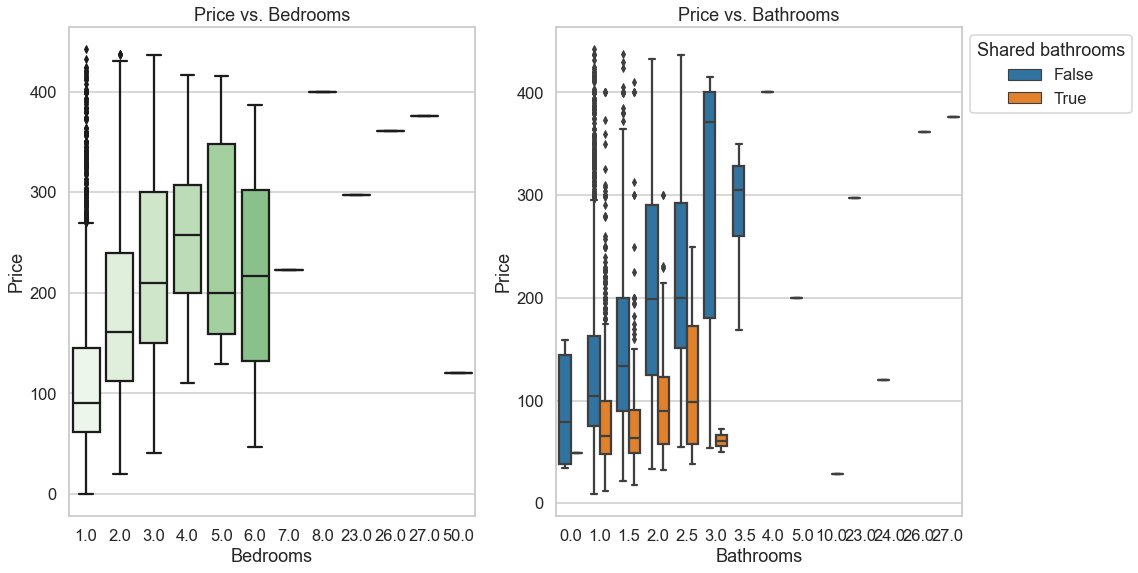

In [25]:
plt.figure(figsize=(16, 9))

plt.subplot(1, 2, 1)
ax1 = sns.boxplot(data=data_cleaned, x="bedrooms", y="price", palette="Greens")
ax1.set_title("Price vs. Bedrooms")
ax1.set_xlabel("Bedrooms")
ax1.set_ylabel("Price")

plt.subplot(1, 2, 2)
ax2 = sns.boxplot(
    data=data_cleaned,
    x="bathrooms",
    y="price",
    hue="bathrooms_is_shared",
)
ax2.set_title("Price vs. Bathrooms")
ax2.set_xlabel("Bathrooms")
ax2.set_ylabel("Price")
sns.move_legend(
    ax2, "upper left", bbox_to_anchor=(1, 1), ncol=1, title="Shared bathrooms"
)

plt.show()

### How do amenities offered influence the price?

There are ~1600 unique amenities offered by the listings. We can look at the top 20 amenities offered by the listings and create dummies for them.

In [26]:
# Look at popular 20 amenities
list_of_amenities.head(20).style.background_gradient(
    sns.light_palette("green", as_cmap=True)
).set_properties(**{"text-align": "center"}).set_table_styles(
    [
        dict(selector="th", props=[("text-align", "center")]),
        dict(
            selector="caption", props=[("font-size", "14px"), ("font-weight", "bold")]
        ),
    ],
).hide().set_caption(
    f"Number of amenities by listings in {city.capitalize()}"
).relabel_index(
    {0: "Amenity", 1: "# of listings"},
    axis="columns",
)

Amenity,# of listings
Kitchen,4829
Wifi,4775
Smoke alarm,4666
Essentials,4356
Hair dryer,3957
Hot water,3726
Dishes and silverware,3652
Hangers,3525
Refrigerator,3298
Cooking basics,3287


In [27]:
amenities_dummies = (
    data_cleaned["amenities"]
    .apply(lambda x: ";".join(set(x.split(", ")).intersection(set(top_20_amenities))))
    .str.get_dummies(sep=";")
)

data_cleaned = pd.concat([data_cleaned, amenities_dummies], axis=1)

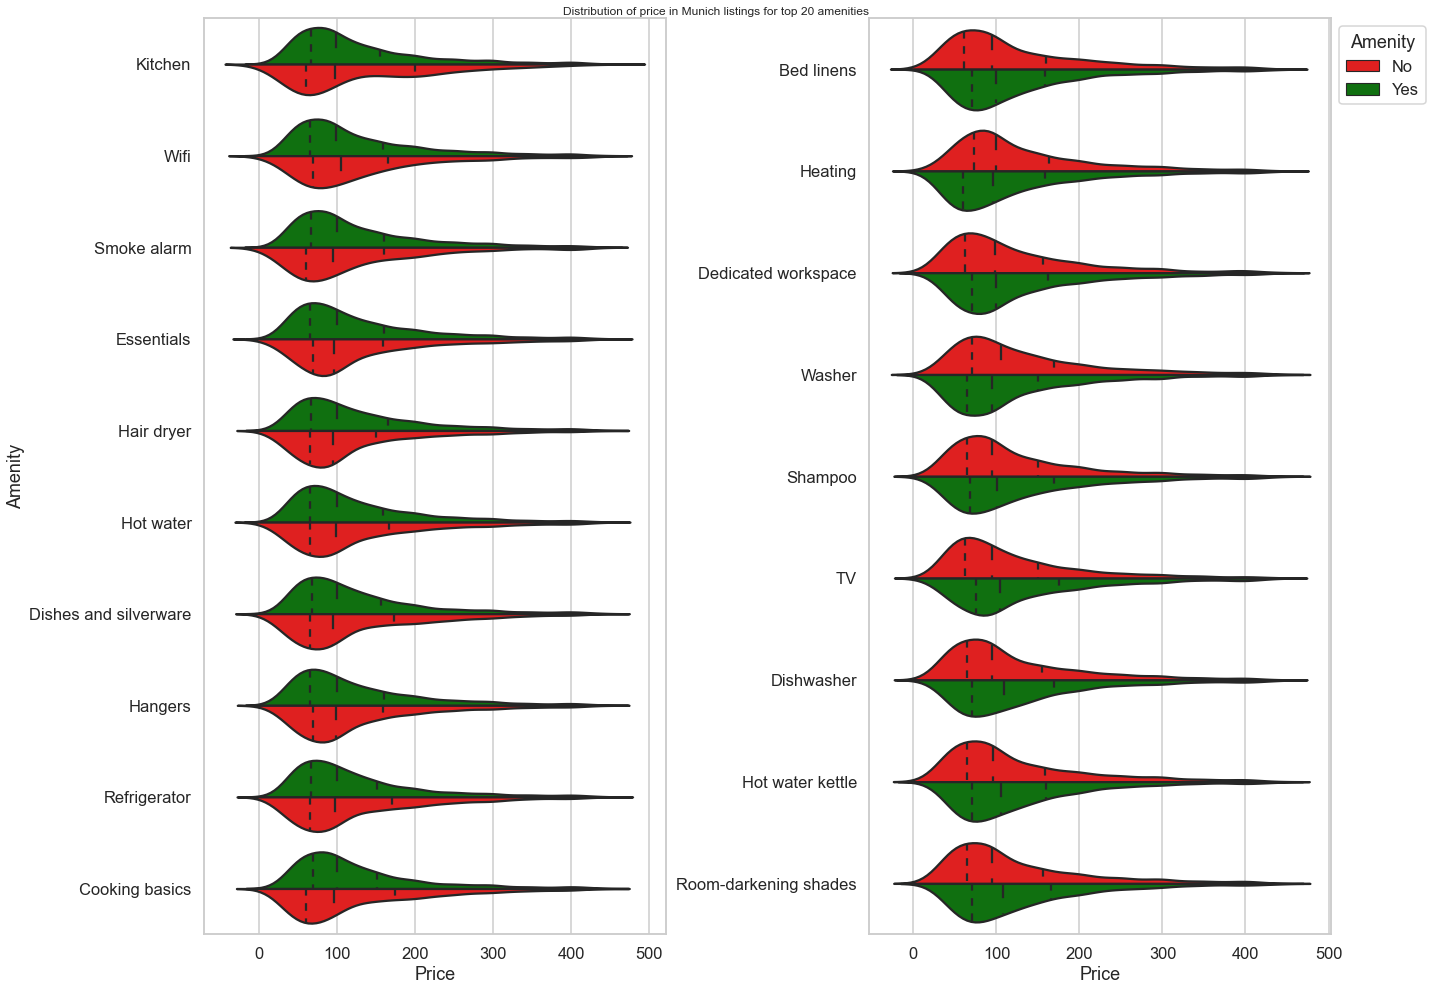

In [28]:
# Visualizing the average price of listings with and without amenities
plt.figure(figsize=(20, 14))
plt.subplot(1, 2, 1)

temp = (
        data_cleaned.loc[:, ["price"] + top_20_amenities[:10]]
        .melt(id_vars="price", var_name="amenity", value_name="amenity_present")
        .replace({1: "Yes", 0: "No"})
    )

temp['price'] = pd.to_numeric(temp['price'], errors='coerce')


ax1 = sns.violinplot(
    temp,
    y="amenity",
    x="price",
    hue="amenity_present",
    split=True,
    inner="quartile",
    palette={"Yes": "green", "No": "red"},
)
ax1.set_xlabel("Price")
ax1.set_ylabel("Amenity")
ax1.legend_.remove()

plt.subplot(1, 2, 2)

temp = (
        data_cleaned.loc[:, ["price"] + top_20_amenities[11:]]
        .melt(id_vars="price", var_name="amenity", value_name="amenity_present")
        .replace({1: "Yes", 0: "No"})
    )

temp['price'] = pd.to_numeric(temp['price'], errors='coerce')



ax2 = sns.violinplot(
    temp,
    y="amenity",
    x="price",
    hue="amenity_present",
    split=True,
    inner="quartile",
    palette={"Yes": "green", "No": "red"},
)
ax2.set_xlabel("Price")
ax2.set_ylabel(None)
sns.move_legend(ax2, "upper left", bbox_to_anchor=(1, 1), ncol=1, title="Amenity")


plt.suptitle(
    f"Distribution of price in {city.capitalize()} listings for top 20 amenities"
)
plt.tight_layout()
plt.show()

From the above, we see that the presence of most amenities tend to increase the price of a listing. We can use this information to create a new feature called `num_amenities` which is the total number of amenities offered by a listing.

Further, we can create dummies for the top 20 amenities and use them as features in our model.


### Correlation between numerical features

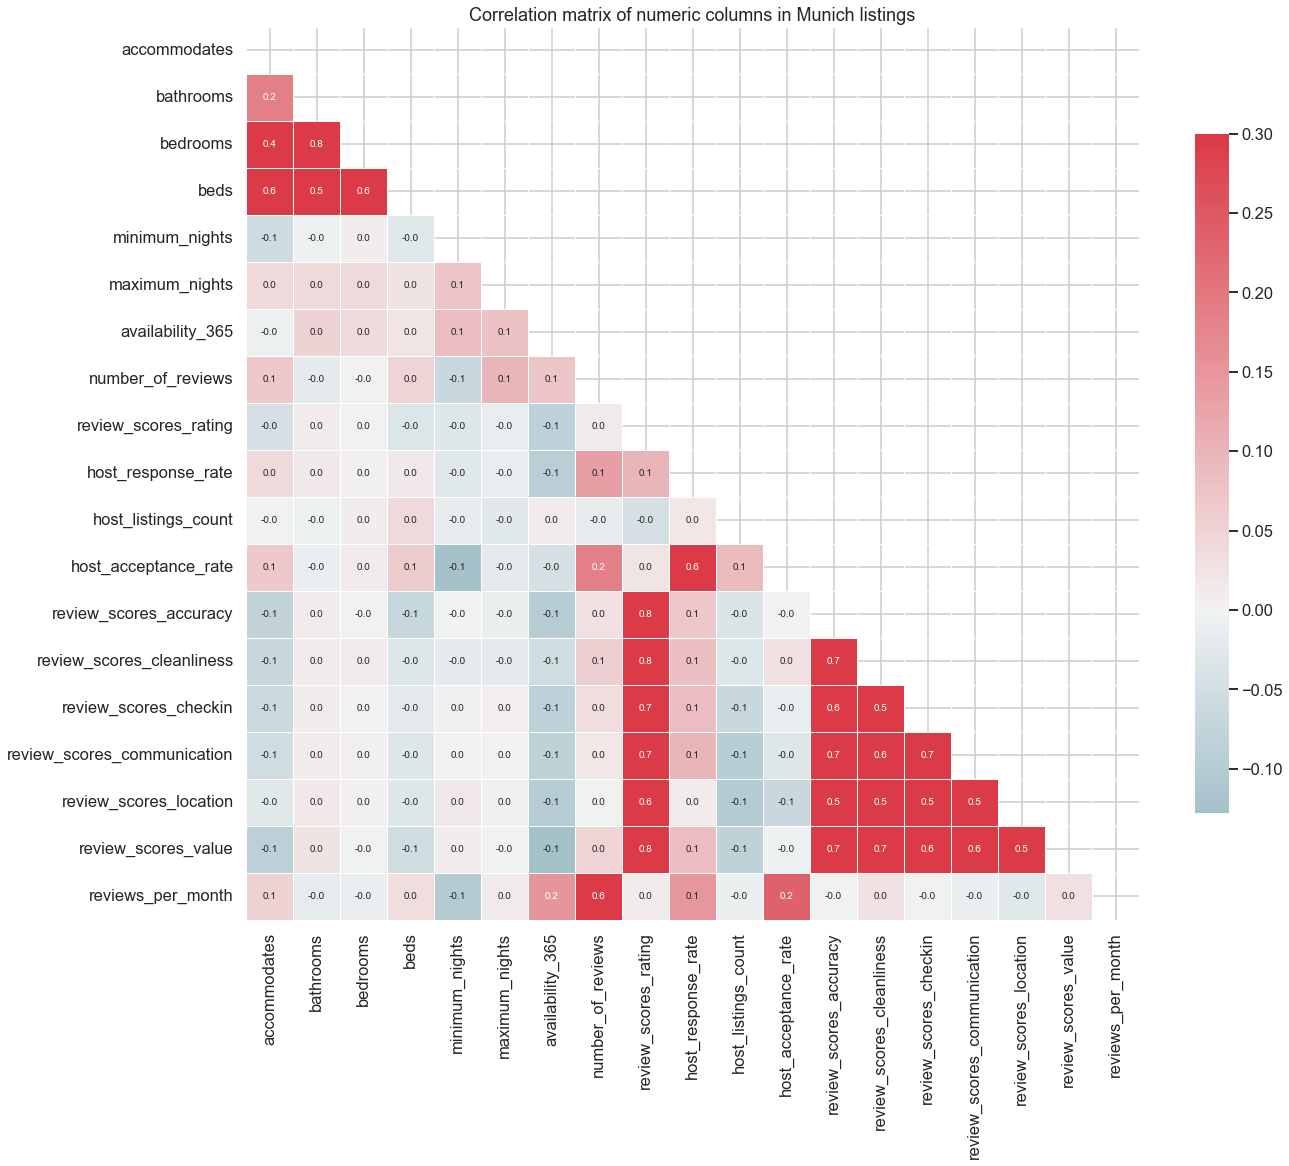

In [29]:
numeric_columns = [
    "accommodates",
    "bathrooms",
    "bedrooms",
    "beds",
    "minimum_nights",
    "maximum_nights",
    "availability_365",
    "number_of_reviews",
    "review_scores_rating",
    "host_response_rate",
    "host_listings_count",
    "host_acceptance_rate",
    "review_scores_accuracy",         
    "review_scores_cleanliness",      
    "review_scores_checkin",          
    "review_scores_communication",    
    "review_scores_location",         
    "review_scores_value",            
    "reviews_per_month"              
]

plt.figure(figsize=(20, 25))
corr = data_cleaned[numeric_columns].corr()
sns.heatmap(
    corr,
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    cmap=sns.diverging_palette(220, 10, as_cmap=True, center="light"),
    vmax=0.3,
    center=0,
    square=True,
    annot=True,
    fmt=".1f",
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)

plt.title(f"Correlation matrix of numeric columns in {city.capitalize()} listings")
plt.show()

### Considering the fact that bedrooms and bathrooms have a high corrleation of 0.8, we can have only 1 in our model, but let's calculate VIF as well to be sure

### To calculate VIF we have to handle the NaNs first, using KNNImputer to fill missing values with values from the nearest neighbors

In [30]:
#Counting NaNs
data_cleaned[numeric_columns].isnull().sum()

accommodates                      0
bathrooms                        37
bedrooms                          0
beds                             72
minimum_nights                    0
maximum_nights                    0
availability_365                  0
number_of_reviews                 0
review_scores_rating           1041
host_response_rate             1489
host_listings_count               0
host_acceptance_rate            799
review_scores_accuracy         1049
review_scores_cleanliness      1049
review_scores_checkin          1050
review_scores_communication    1049
review_scores_location         1049
review_scores_value            1049
reviews_per_month              1041
dtype: int64

In [31]:
#Using K nearest neighbors to impute missing values
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
data_cleaned[numeric_columns] = imputer.fit_transform(data_cleaned[numeric_columns])

data_cleaned[numeric_columns].isnull().sum()

accommodates                   0
bathrooms                      0
bedrooms                       0
beds                           0
minimum_nights                 0
maximum_nights                 0
availability_365               0
number_of_reviews              0
review_scores_rating           0
host_response_rate             0
host_listings_count            0
host_acceptance_rate           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
reviews_per_month              0
dtype: int64

### Calculating the VIF

In [32]:
#Calculating VIF for all numeric columns except price
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(data_cleaned[numeric_columns].values, i) for i in range(data_cleaned[numeric_columns].shape[1])]
vif["Column"] = numeric_columns
vif.sort_values(by="VIF", ascending=False)

,VIF,Column
15,681.651362,review_scores_communication
12,649.535879,review_scores_accuracy
14,513.873614,review_scores_checkin
8,359.093160,review_scores_rating
17,347.539885,review_scores_value
13,309.726377,review_scores_cleanliness
16,291.384706,review_scores_location
9,21.778492,host_response_rate
11,10.330555,host_acceptance_rate
1,9.970925,bathrooms


### Based on the correlations and the VIFs above we will remove some of the highly correlated columns like all the review_scores beds, host_response_rate, bathrooms etc and calculating VIF again

In [33]:
#Removing columns with high VIF
numeric_columns.remove("host_response_rate")
numeric_columns.remove("bedrooms")
numeric_columns.remove("beds")
numeric_columns.remove("review_scores_rating")
numeric_columns.remove("review_scores_communication")
numeric_columns.remove("review_scores_cleanliness")
numeric_columns.remove("review_scores_accuracy")
numeric_columns.remove("review_scores_location")
numeric_columns.remove("review_scores_value")
numeric_columns.remove("review_scores_checkin")

#Calculating VIF again
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(data_cleaned[numeric_columns].values, i) for i in range(data_cleaned[numeric_columns].shape[1])]
vif["Column"] = numeric_columns
vif.sort_values(by="VIF", ascending=False)

,VIF,Column
7,4.122357,host_acceptance_rate
0,3.608996,accommodates
1,3.138237,bathrooms
8,2.455007,reviews_per_month
5,1.982058,number_of_reviews
3,1.843933,maximum_nights
4,1.776274,availability_365
2,1.125155,minimum_nights
6,1.040013,host_listings_count


In [34]:
#Removing columns with high VIF from the dataframe
data_cleaned.drop(["host_response_rate", "bedrooms", "beds", "review_scores_rating","review_scores_communication","review_scores_cleanliness","review_scores_accuracy","review_scores_location","review_scores_value","review_scores_checkin"], axis=1, inplace=True)

data_cleaned.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,bathrooms_is_shared,num_amenities,Bed linens,Cooking basics,Dedicated workspace,Dishes and silverware,Dishwasher,Essentials,Hair dryer,Hangers,Heating,Hot water,Hot water kettle,Iron,Kitchen,Refrigerator,Room-darkening shades,Shampoo,Smoke alarm,TV,Washer,Wifi
0,651278636295313943,https://www.airbnb.com/rooms/651278636295313943,20230627053437,2023-06-27,city scrape,Condo in Munich · ★4.38 · 1 bedroom · 2 beds ·...,NaN,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,286578863,https://www.airbnb.com/users/show/286578863,Tobias,2019-08-17,"Munich, Germany","Hey there, my name is Tobias, I‘m from Austria...",within an hour,100.0,False,https://a0.muscache.com/im/pictures/user/a01df...,https://a0.muscache.com/im/pictures/user/a01df...,NaN,1.0,2,"['email', 'phone', 'work_email']",True,True,NaN,Bogenhausen,NaN,48.173418,11.635056,Entire condo,Entire home/apt,3.0,1.0,1 bath,"TV, First aid kit, Smoke alarm, Elevator, Self...",104.0,1.0,14.0,1,1,1125,1125,1.0,1125.0,NaN,True,12,32,38,38.0,2023-06-27,24.0,24,4,2022-09-18,2023-06-23,NaN,True,1,1,0,0,2.54,False,4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1
1,51979073,https://www.airbnb.com/rooms/51979073,20230627053437,2023-06-27,previous scrape,Rental unit in Munich · ★4.61 · 1 bedroom · 2 ...,Enjoy the simple life in this quiet and centra...,Maxvorstadt is a bustling district: it is home...,https://a0.muscache.com/pictures/a149c822-8207...,146200788,https://www.airbnb.com/users/show/146200788,Dustin,2017-08-15,"Munich, Germany",NaN,a few days or more,27.0,False,https://a0.muscache.com/im/pictures/user/8d2e2...,https://a0.muscache.com/im/pictures/user/8d2e2...,NaN,1.0,1,"['email', 'phone']",True,True,"Munich, Bayern, Germany",Maxvorstadt,NaN,48.149384,11.576812,Entire rental unit,Entire home/apt,2.0,1.0,1 bath,"Freezer, Hangers, Clothing storage: closet and...",72.0,5.0,365.0,3,3,365,365,3.0,365.0,NaN,True,0,0,0,0.0,2023-06-27,18.0,6,0,2021-09-18,2023-03-12,NaN,False,1,1,0,0,0.83,False,16,1,1,1,1,0,1,1,1,0,1,1,1,1,1,1,1,1,0,0,1
2,44605632,https://www.airbnb.com/rooms/44605632,20230627053437,2023-06-27,previous scrape,Rental unit in Munich · ★5.0 · 2 bedrooms · 2 ...,Centrally located in Munich's trending but qui...,5-min walk to trams<br />8-minute walk from po...,https://a0.muscache.com/pictures/13da8e75-9778...,7936197,https://www.airbnb.com/users/show/7936197,Waleska,2013-08-04,"Munich, Germany",With nearly 10 consecutive years living abroad...,NaN,68.0,False,https://a0.muscache.com/im/pictures/user/61ebf...,https://a0.muscache.com/im/pictures/user/61ebf...,NaN,1.0,2,"['email', 'phone', 'work_email']",True,True,"Munich, Bayern, Germany",Schwanthalerhöhe,NaN,48.139170,11.529930,Entire rental unit,Entire home/apt,4.0,1.0,1 bath,"Freezer, Hangers, First aid kit, Coffee maker,...",64.0,5.0,1125.0,5,5,1125,1125,5.0,1125.0,NaN,True,0,0,0,0.0,2023-06-27,7.0,0,0,2020-08-16,2022-04-20,N

### We also have a lot of text columns which contain URLs and names and thus are essentially useless, so we would remove those columns now

In [35]:
#Removing useless text columns

cols_to_drop = ["id","listing_url","scrape_id","last_scraped","source",
                 "name","description","neighborhood_overview","picture_url",
                 "host_id","host_url","host_name","host_since","host_location","host_about",
                 "host_thumbnail_url","host_picture_url","host_neighbourhood","calendar_last_scraped",
                 "first_review","last_review","license","calendar_updated","neighbourhood_group_cleansed",
                 "amenities","host_has_profile_pic","host_identity_verified"]

data_cleaned.drop(cols_to_drop, axis=1, inplace=True)
data_cleaned.head()


,host_response_time,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,bathrooms_is_shared,num_amenities,Bed linens,Cooking basics,Dedicated workspace,Dishes and silverware,Dishwasher,Essentials,Hair dryer,Hangers,Heating,Hot water,Hot water kettle,Iron,Kitchen,Refrigerator,Room-darkening shades,Shampoo,Smoke alarm,TV,Washer,Wifi
0,within an hour,100.0,False,1.0,2,"['email', 'phone', 'work_email']",NaN,Bogenhausen,48.173418,11.635056,Entire condo,Entire home/apt,3.0,1.0,1 bath,104.0,1.0,14.0,1,1,1125,1125,1.0,1125.0,True,12,32,38,38.0,24.0,24,4,True,1,1,0,0,2.54,False,4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1
1,a few days or more,27.0,False,1.0,1,"['email', 'phone']","Munich, Bayern, Germany",Maxvorstadt,48.149384,11.576812,Entire rental unit,Entire home/apt,2.0,1.0,1 bath,72.0,5.0,365.0,3,3,365,365,3.0,365.0,True,0,0,0,0.0,18.0,6,0,False,1,1,0,0,0.83,False,16,1,1,1,1,0,1,1,1,0,1,1,1,1,1,1,1,1,0,0,1
2,NaN,68.0,False,1.0,2,"['email', 'phone', 'work_email']","Munich, Bayern, Germany",Schwanthalerhöhe,48.139170,11.529930,Entire rental unit,Entire home/apt,4.0,1.0,1 bath,64.0,5.0,1125.0,5,5,1125,1125,5.0,1125.0,True,0,0,0,0.0,7.0,0,0,True,1,1,0,0,0.20,False,16,0,1,0,1,1,1,1,1,1,1,0,1,1,1,0,1,1,1,1,1
3,NaN,65.8,False,1.0,4,"['email', 'phone']",NaN,Altstadt-Lehel,48.134300,11.580270,Entire rental unit,Entire home/apt,2.0,1.0,1 bath,48.0,6.0,14.0,6,6,1125,1125,6.0,1125.0,True,0,0,0,0.0,7.0,0,0,True,1,1,0,0,0.20,False,8,0,0,0,0,0,1,0,0,1,1,0,1,1,0,0,0,1,0,1,1
4,NaN,50.0,False,1.0,1,"['email', 'phone']",NaN,Ludwigsvorstadt-Isarvorstadt,48.125090,11.551480,Entire rental unit,Entire home/apt,6.0,1.0,1 bath,379.0,2.0,14.0,2,2,14,14,2.0,14.0,True,0,0,0,0.0,0.0,0,0,False,1,1,0,0,0.12,False,8,0,1,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,1


### Now Removing the room_type column as it is highly correlated with property_type

In [36]:
data_cleaned.drop(["room_type"], axis=1, inplace=True)
data_cleaned.head()

,host_response_time,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,accommodates,bathrooms,bathrooms_text,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,bathrooms_is_shared,num_amenities,Bed linens,Cooking basics,Dedicated workspace,Dishes and silverware,Dishwasher,Essentials,Hair dryer,Hangers,Heating,Hot water,Hot water kettle,Iron,Kitchen,Refrigerator,Room-darkening shades,Shampoo,Smoke alarm,TV,Washer,Wifi
0,within an hour,100.0,False,1.0,2,"['email', 'phone', 'work_email']",NaN,Bogenhausen,48.173418,11.635056,Entire condo,3.0,1.0,1 bath,104.0,1.0,14.0,1,1,1125,1125,1.0,1125.0,True,12,32,38,38.0,24.0,24,4,True,1,1,0,0,2.54,False,4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1
1,a few days or more,27.0,False,1.0,1,"['email', 'phone']","Munich, Bayern, Germany",Maxvorstadt,48.149384,11.576812,Entire rental unit,2.0,1.0,1 bath,72.0,5.0,365.0,3,3,365,365,3.0,365.0,True,0,0,0,0.0,18.0,6,0,False,1,1,0,0,0.83,False,16,1,1,1,1,0,1,1,1,0,1,1,1,1,1,1,1,1,0,0,1
2,NaN,68.0,False,1.0,2,"['email', 'phone', 'work_email']","Munich, Bayern, Germany",Schwanthalerhöhe,48.139170,11.529930,Entire rental unit,4.0,1.0,1 bath,64.0,5.0,1125.0,5,5,1125,1125,5.0,1125.0,True,0,0,0,0.0,7.0,0,0,True,1,1,0,0,0.20,False,16,0,1,0,1,1,1,1,1,1,1,0,1,1,1,0,1,1,1,1,1
3,NaN,65.8,False,1.0,4,"['email', 'phone']",NaN,Altstadt-Lehel,48.134300,11.580270,Entire rental unit,2.0,1.0,1 bath,48.0,6.0,14.0,6,6,1125,1125,6.0,1125.0,True,0,0,0,0.0,7.0,0,0,True,1,1,0,0,0.20,False,8,0,0,0,0,0,1,0,0,1,1,0,1,1,0,0,0,1,0,1,1
4,NaN,50.0,False,1.0,1,"['email', 'phone']",NaN,Ludwigsvorstadt-Isarvorstadt,48.125090,11.551480,Entire rental unit,6.0,1.0,1 bath,379.0,2.0,14.0,2,2,14,14,2.0,14.0,True,0,0,0,0.0,0.0,0,0,False,1,1,0,0,0.12,False,8,0,1,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,1


In [37]:
#Counting NaNs in categorical columns and printing those with more than one
categorical_columns = data_cleaned.select_dtypes(include="object").columns
data_cleaned[categorical_columns].isnull().sum()

#Creating a list of categorical columns with more than one NaN
categorical_columns_to_drop = data_cleaned[categorical_columns].isnull().sum()[data_cleaned[categorical_columns].isnull().sum() > 1].index.to_list()

In [38]:
#Printing the number of NaNs and total number of rows for each column
for col in categorical_columns_to_drop:
    print(f"{col}: {data_cleaned[col].isnull().sum()} NaNs out of {data_cleaned.shape[0]} rows")

host_response_time: 1489 NaNs out of 5391 rows
neighbourhood: 3008 NaNs out of 5391 rows
bathrooms_text: 5 NaNs out of 5391 rows
bathrooms_is_shared: 5 NaNs out of 5391 rows


- Considering the fact that Neighbourhood has ~60% NaNs , we can remove this column and just keep the cleansed one. 
- As ~30% values are NaN for response time, we can replace it with the mode value for response time column
- We can drop the rows with 5 NaNs in bathrooms and Bathrooms is shared columns

In [39]:
#Getting value counts for all unique values in response time column
data_cleaned["host_response_time"].value_counts()

within an hour        1724
within a few hours     956
within a day           894
a few days or more     328
Name: host_response_time, dtype: int64

In [40]:
# Removing the Neighborhood column as it has too many NaNs
data_cleaned.drop("neighbourhood", axis=1, inplace=True)
#Replacing NaNs with one of the unique values currently there with chance proportional to the frequency of the value
response_times = ["within an hour", "within a few hours", "within a day", "a few days or more"]
weights = [0.5, 0.2, 0.2, 0.1]

# Fill NaN values in "host_response_time" using random.choices
data_cleaned["host_response_time"].fillna(pd.Series(random.choices(response_times, weights, k=len(data))), inplace=True)

#Dropping the NaNs for bathrooms_text column and bathroom is shared column
data_cleaned.dropna(subset=["bathrooms_text", "bathrooms_is_shared"], inplace=True)

In [41]:
#Counting the number of unique values in all text columns
text_columns = data_cleaned.select_dtypes(include="object").columns
for col in text_columns:
    print(f"{col}: {data_cleaned[col].nunique()} unique values")

host_response_time: 4 unique values
host_verifications: 6 unique values
neighbourhood_cleansed: 25 unique values
property_type: 50 unique values
bathrooms_text: 24 unique values
bathrooms_is_shared: 2 unique values


In [42]:
#Creating dummies for all text columns
data_cleaned = pd.get_dummies(data_cleaned, columns=text_columns, drop_first=True)
data_cleaned.head()

,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,num_amenities,Bed linens,Cooking basics,Dedicated workspace,Dishes and silverware,Dishwasher,Essentials,Hair dryer,Hangers,Heating,Hot water,Hot water kettle,Iron,Kitchen,Refrigerator,Room-darkening shades,Shampoo,Smoke alarm,TV,Washer,Wifi,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,"host_verifications_['email', 'phone']",host_verifications_['email'],"host_verifications_['phone', 'work_email']",host_verifications_['phone'],host_verifications_[],neighbourhood_cleansed_Altstadt-Lehel,neighbourhood_cleansed_Au-Haidhausen,neighbourhood_cleansed_Aubing-Lochhausen-Langwied,neighbourhood_cleansed_Berg am Laim,neighbourhood_cleansed_Bogenhausen,neighbourhood_cleansed_Feldmoching-Hasenbergl,neighbourhood_cleansed_Hadern,neighbourhood_cleansed_Laim,neighbourhood_cleansed_Ludwigsvorstadt-Isarvorstadt,neighbourhood_cleansed_Maxvorstadt,neighbourhood_cleansed_Milbertshofen-Am Hart,neighbourhood_cleansed_Moosach,neighbourhood_cleansed_Neuhausen-Nymphenburg,neighbourhood_cleansed_Obergiesing,neighbourhood_cleansed_Pasing-Obermenzing,neighbourhood_cleansed_Ramersdorf-Perlach,neighbourhood_cleansed_Schwabing-Freimann,neighbourhood_cleansed_Schwabing-West,neighbourhood_cleansed_Schwanthalerhöhe,neighbourhood_cleansed_Sendling,neighbourhood_cleansed_Sendling-Westpark,neighbourhood_cleansed_Thalkirchen-Obersendling-Forstenried-Fürstenried-Solln,neighbourhood_cleansed_Tudering-Riem,neighbourhood_cleansed_Untergiesing-Harlaching,property_type_Camper/RV,property_type_Casa particular,property_type_Entire bungalow,property_type_Entire chalet,property_type_Entire condo,property_type_Entire guest suite,property_type_Entire guesthouse,property_type_Entire home,property_type_Entire home/apt,property_type_Entire loft,property_type_Entire place,property_type_Entire rental unit,property_type_Entire serviced apartment,property_type_Entire townhouse,property_type_Entire vacation home,property_type_Entire villa,property_type_Hut,property_type_Pension,property_type_Private room,property_type_Private room in bed and breakfast,property_type_Private room in bungalow,property_type_Private room in camper/rv,property_type_Private room in casa particular,property_type_Private room in condo,property_type_Private room in guest suite,property_type_Private room in guesthouse,property_type_Private room in home,property_type_Private room in hostel,property_type_Private room in loft,property_type_Private room in rental unit,property_type_Private room in serviced apartment,property_type_Private room in tent,property_type_Private room in townhouse,property_type_Private room in vacation home,property_type_Private room in villa,property_type_Room in aparthotel,property_type_Room in bed and breakfast,property_type_Room in boutique hotel,property_type_Room in hotel,property_type_Room in serviced apartment,property_type_Shared room in bed and breakfast,property_type_Shared room in condo,property_type_Shared room in home,property_type_Shared room in ice dome,property_type_Shared room in loft,property_type_Shared room in rental unit,property_type_Shared room in tent,property_type_Shared room in tipi,property_type_Tiny home,bathrooms_text_0 shared baths,bathrooms_text_1 bath,bathrooms_text_1 private bath,bathrooms_text_1 shared bath,bathrooms_text_1.5 baths,bathrooms_text_1.5 shared baths,bat

### Modeling Approach

### Using PyCaret to find the most suitable model for our regression analysis

In [43]:
# Ensuring that feature names are strings and removing any special characters
data_cleaned.columns = data_cleaned.columns.str.replace('[\[\]<>]', '', regex=True).astype(str)

#Dividing the data into X and Y with price being the target variable
X = data_cleaned.drop("price", axis=1)
Y = data_cleaned["price"]

#Using pycaret to find the best model
from pycaret.regression import *
reg = setup(data_cleaned, target="price", session_id=123, log_experiment=True, experiment_name="airbnb_price_prediction")
best_model = compare_models()




,Description,Value
0,Session id,123
1,Target,price
2,Target type,Regression
3,Original data shape,"(5386, 157)"
4,Transformed data shape,"(5386, 157)"
5,Transformed train set shape,"(3770, 157)"
6,Transformed test set shape,"(1616, 157)"
7,Numeric features,153
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,40.7155,3524.0831,59.1782,0.4933,0.4305,0.3942,0.1290
gbr,Gradient Boosting Regressor,42.8433,3724.4927,60.8742,0.4637,0.4513,0.4255,0.2710
rf,Random Forest Regressor,43.3577,3842.8865,61.8746,0.4454,0.4588,0.4398,1.2360
xgboost,Extreme Gradient Boosting,43.3891,3866.1620,62.0827,0.4407,0.4703,0.4241,0.1280
et,Extra Trees Regressor,45.4376,4242.8981,65.0347,0.3869,0.4782,0.4573,0.9270
ridge,Ridge Regression,46.6780,4353.8351,65.8232,0.3719,0.5051,0.4676,0.0300
br,Bayesian Ridge,46.7886,4404.0459,66.1845,0.3650,0.5033,0.4713,0.0680
lasso,Lasso Regression,49.4008,4789.5056,68.9940,0.3099,0.5258,0.5080,0.7890
llar,Lasso Least Angle Regression,49.4276,4792.0758,69.0155,0.3094,0.5261,0.5082,0.0260
en,Elastic Net,51.0475,4927.5396,70.0119,0.2902,0.5410,0.5374,0.3580


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

In [ ]:
#Getting the best model params
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
#Now Using GridSearchCV to find the best model and params for our data based on R2 score. We would fit in models like Linear Regression, Lasso, Ridge, ElasticNet, Decision Tree, Random Forest, XGBoost, LightGBM and CatBoost and ANN using MLP Classifiers and then feed some hyperparameters to GridSearchCV to find the best model and params

#Step 1 Using StandardScaler to scale the whole data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

#Step 2 importing all the models
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor

#Step 3 Creating a dictionary of all the models

models = {
    
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "ElasticNet": ElasticNet(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "LightGBM": LGBMRegressor(),
    "CatBoost": CatBoostRegressor(),
    "MLP": MLPRegressor()
}


#Creating a dictionary for hyperparameters for each model

params = {

    "Linear Regression": {
        "fit_intercept": [True, False],
        "normalize": [True, False]
    },
    "Lasso": {
        "alpha": [0.1, 0.5, 1, 2, 5],
        "selection": ["cyclic", "random"]
    },
    "Ridge": {
        "alpha": [0.1, 0.5, 1, 2, 5],
        "solver": ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"]
    },
    "ElasticNet": {
        "alpha": [0.1, 0.5, 1, 2, 5],
        "l1_ratio": [0.1, 0.5, 1, 2, 5],
        "selection": ["cyclic", "random"]
    },
    "Decision Tree": {
        "criterion": ["mse", "friedman_mse", "mae"],
        "splitter": ["best", "random"],
        "max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10]
    },
    "Random Forest": {
        "n_estimators": [100, 200, 300, 400, 500],
        "criterion": ["mse", "mae"],
        "max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10]
    },
    "XGBoost": {
        "n_estimators": [100, 200, 300, 400, 500],
        "max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10],
        "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3]
    },
    "LightGBM": {
        "n_estimators": [100, 200, 300, 400, 500],
        "max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10],
        "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3]
    },
    "CatBoost": {
        "n_estimators": [100, 200, 300, 400, 500],
        "max_depth": [2, 3, 4, 5, 6, 7, 8, 9, 10],
        "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3]
    },
    "MLP": {
        "hidden_layer_sizes": [(100,), (200,), (300,), (400,), (500,)],
        "activation": ["identity", "logistic", "tanh", "relu"],
        "solver": ["lbfgs", "sgd", "adam"],
        "alpha": [0.0001, 0.001, 0.01, 0.1],
        "learning_rate": ["constant", "invscaling", "adaptive"]
    }
}

#Step 4 Importing GridSearchCV and creating a dictionary for all the models

from sklearn.model_selection import GridSearchCV
grid_search_models = {}

#Step 5 Creating a function to find the best model and params for each model

def find_best_model(model_name, model, params):
    grid = GridSearchCV(model, params, cv=5, scoring="r2", n_jobs=-1, verbose=1)
    grid.fit(X, Y)
    grid_search_models[model_name] = {
        "best_score": grid.best_score_,
        "best_params": grid.best_params_
    }
    print(f"Best Score: {grid.best_score_}")
    print(f"Best Params: {grid.best_params_}")

#Step 6 Running the function for each model

for model_name, model in models.items():
    find_best_model(model_name, model, params[model_name])

#Step 7 Printing the best model and params for each model

for model_name, model in grid_search_models.items():
    print(f"{model_name}: {model}")
